In [1]:
%%writefile src/mpi_io.py

from mpi4py import MPI
import numpy as np

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Define the size of the shared numpy array
array_size = 10000  # Adjust the size as needed

# Create a numpy array for each rank
local_data = np.arange(array_size, dtype=np.float64)

# Create a filename for each rank
filename = f"data/data_rank_{rank}.npy"

# Save the local_data to a file
with open(filename,"wb") as f:
    print(f"Process {rank} writing {filename} ..")
    np.save(f, local_data)

# Barrier to synchronize processes before reading
comm.Barrier()


# Finalize MPI
MPI.Finalize()

Overwriting src/mpi_io.py


In [2]:
!mpiexec -n 2 python src/mpi_io.py

Process 0 writing data/data_rank_0.npy ..
Process 1 writing data/data_rank_1.npy ..


In [4]:
!mpiexec -n 2 bash src/smp.sh python src/mpi_io.py

logs/python_a65243794be3_24779.st
logs/python_a65243794be3_24781.st
strace: decode_nlattr: [xlat 0x5607740f92c0, dflt "AF_???", decoders 0x7fff4f2893b0] size is zero (going to pass nla_type as decoder argument), but opaque data (0x7fff4f289470) is not - will be ignored
strace: decode_nlattr: [xlat 0x56258a50b2c0, dflt "AF_???", decoders 0x7fffb2de62b0] size is zero (going to pass nla_type as decoder argument), but opaque data (0x7fffb2de6370) is not - will be ignored
strace: decode_nlattr: [xlat 0x56258a50b2c0, dflt "AF_???", decoders 0x7fffb2de62b0] size is zero (going to pass nla_type as decoder argument), but opaque data (0x7fffb2de6370) is not - will be ignored
strace: decode_nlattr: [xlat 0x5607740f92c0, dflt "AF_???", decoders 0x7fff4f2893b0] size is zero (going to pass nla_type as decoder argument), but opaque data (0x7fff4f289470) is not - will be ignored
strace: decode_nlattr: [xlat 0x56258a50b2c0, dflt "AF_???", decoders 0x7fffb2de62b0] size is zero (going to pass nla_type as

In [1]:
from strace_miner.core.strace_analyzer import StraceAnalyzer
from strace_miner.core.preprocessor import Preprocessor

In [392]:
%%writefile ../strace_miner/views/v4/io_miner_v4.py

from ...core.strace_analyzer import StraceAnalyzer
from ...core.preprocessor import Preprocessor
import os
import pm4py
import pandas as pd
from datetime import timedelta


class IOMinerV4(StraceAnalyzer):
    def __init__(self,st_log_paths,io_calls,line_reader):
        super().__init__(st_log_paths)
        self.io_calls = io_calls
        self.line_reader = line_reader
        self.overall_summary = {}
        self.activities_summary = {}
        self.activities = None
        self.filtered_duration = 0.0

    
    def preprocess(self, reuse=False):
        for st_path in self.st_log_paths: 
              st = Preprocessor(st_path,self.io_calls,self.line_reader,'IO')
              st.extra = ['bytes','fs']
              case_id = os.path.basename(st_path).split('.st')[0]
              if not reuse:
                st.prepare_csv_log()
            
              self.st_logs[case_id] = st
    
    def prepare_summaries_and_event_log(self):
          df = []
          for case,st in self.st_logs.items():
               df_ = st.get_df_from_csv()
               #df_ = df_[df_['call'].isin(self.io_calls)]
               df_['case'] = case
               df_['time'] = pd.to_datetime(df_['time'],format='%H:%M:%S.%f')
               df_['duration'] = df_['duration'].apply(lambda x: max(0.0,x))
               df_['end'] = df_['time'] + df_['duration'].apply(lambda x: timedelta(seconds=x)) 
               df_['event'] = df_['call'] + '\n' + df_['bytes'].astype(str) + '\n' + df_['fs']
               df.append(df_)
          df = pd.concat(df,ignore_index=True)

          df = self._prepare_overall_summary_and_filter(df)
          self._prepare_events_summary(df)

          df = pm4py.format_dataframe(df,case_id='case',activity_key='event',timestamp_key='time')
          self.el = pm4py.convert_to_event_log(df)     
    
    
    def _prepare_overall_summary_and_filter(self,df):
          df = df.sort_values(by='time')
          total_duration = df['duration'].sum()
          total_time = (df['time'].iloc[-1]-df['time'].iloc[0]).total_seconds()
          sys_load = total_duration/total_time
          self.overall_summary['duration'] = total_duration
          self.overall_summary['time'] = total_time
          self.overall_summary['sys_load'] = sys_load

          df = df[df['call'].isin(self.io_calls)]
          self.filtered_duration = df['duration'].sum()
          self.overall_summary['IO_duration'] = self.filtered_duration
          self.overall_summary['IO_load'] = (self.filtered_duration/total_duration)*100.0
          self.activities = df['event'].unique()
          self.overall_summary['Total_events'] = len(self.activities)
          
          self.print_overall_summary()

          return df


    def print_overall_summary(self):
         if not self.overall_summary:
              print("Summary not available!")
              return
         str = "\nOverall Summary:\n\n"
         str += "Run time: {:.3f}s\n".format(self.overall_summary['time'])
         str += "Total duration of Sys calls: {:.3f}s\n".format(self.overall_summary['duration'])
         str += "System load: {:.3f}\n\n".format(self.overall_summary['sys_load'])

         str += "IO duration: {:.3f}s\n".format(self.overall_summary['IO_duration'])
         str += "IO load: {:.2f}%\n".format(self.overall_summary['IO_load'])
         str += "Total IO events: {}\n".format(self.overall_summary['Total_events'])

         print(str)

         
    def _get_max_parallel(self,df):
          px = []
          mp = 0
          for row in df.itertuples():
               r = []
               for x in px:
                    if row.time > x:
                         r.append(x)
               
               for x in r:
                    px.remove(x)

               px.append(row.end)
               if len(px) > mp:
                    mp = len(px)
               #print(row,mp)
          return mp

    def _prepare_events_summary(self,df):
          ret = []
          counts = dict(df['event'].value_counts())
          for event in df['event'].unique():
               df_x = df[df['event']==event]
               e_time = df_x['duration'].sum()
               p = (e_time/self.filtered_duration)*100.0
               mp = self._get_max_parallel(df_x)
               ret.append([event.split('\n'),counts[event],mp,p])
          self.activities_summary = pd.DataFrame(ret,columns=['event','count','max_parallel','io_percent'])

    def print_events_summary(self):
         print(self.activities_summary.to_string(index=False, float_format='{:,.2f}'.format))
         

    def prepare_dfg(self):
         self.dfg,self.dfg_im,self.dfg_fm = pm4py.discover_dfg(self.el)

    def view_dfg(self):
         if self.dfg:
              return pm4py.view_dfg(self.dfg,self.dfg_im,self.dfg_fm)

Writing ../strace_miner/views/v4/io_miner_v4.py


In [393]:
from strace_miner.views.v3.io_line_reader import IOLineReaderV3

st_logs = ['logs/python_a65243794be3_24779.st','logs/python_a65243794be3_24781.st']
#st_logs = ['logs/view3.st',]
io_calls = ['read','write']
#line_reader = IOLineReaderV3(['data_rank',],collapse=True)
line_reader = IOLineReaderV3(['/dev/data/',],collapse=True)
#line_reader = IOLineReaderV3(collapse=False)
sta = IOMinerV4(st_logs,io_calls,line_reader)

In [394]:
sta.preprocess()
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

CSV log path: logs/python_a65243794be3_24779.csv
CSV log path: logs/python_a65243794be3_24781.csv

Overall Summary:

Run time: 1.089s
Total duration of Sys calls: 5.143s
System load: 4.724

IO duration: 0.052s
IO load: 1.00%
Total IO events: 7



/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [395]:
sta.print_events_summary()

                                                        event  count  max_parallel  io_percent
                                            [read, [<4KB],  ]    685             2       62.70
                                            [read, [<4MB],  ]    237             2       27.98
                                           [write, [<4KB],  ]     83             2        8.57
[write, [<4KB], /workspaces/hdf5-tutorial.../data_rank_0.npy]      2             1        0.32
[write, [<4MB], /workspaces/hdf5-tutorial.../data_rank_0.npy]      1             1        0.14
[write, [<4KB], /workspaces/hdf5-tutorial.../data_rank_1.npy]      2             1        0.17
[write, [<4MB], /workspaces/hdf5-tutorial.../data_rank_1.npy]      1             1        0.13


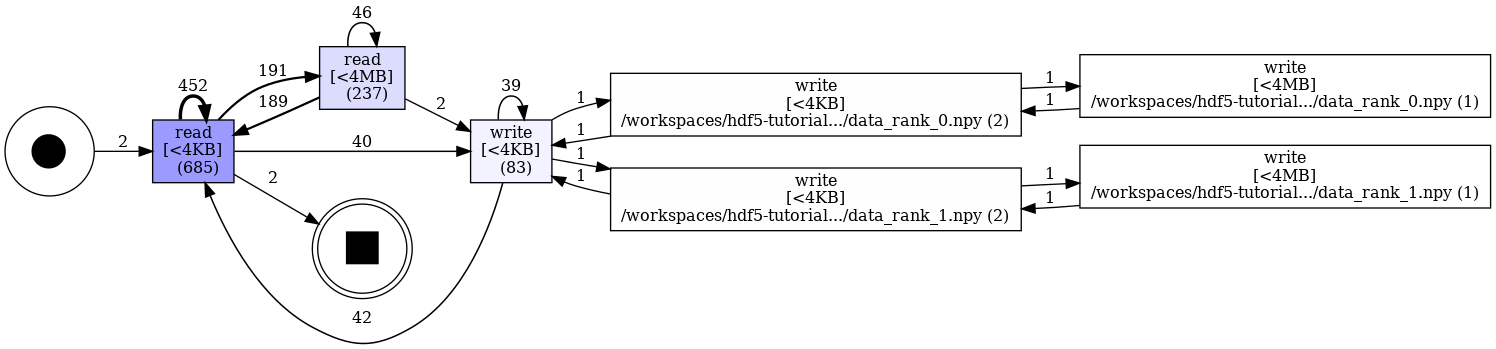

In [396]:
sta.view_dfg()

#### Scratch pad: Getting max parallel for each activity

In [347]:
from datetime import timedelta

df = []
for case,st in sta.st_logs.items():
    df_ = st.get_df_from_csv()
    df_['case'] = case
    df_['time'] = pd.to_datetime(df_['time'],format='%H:%M:%S.%f')
    df_['duration'] = df_['duration'].apply(lambda x: max(0.0,x))
    df_['end'] = df_['time'] + df_['duration'].apply(lambda x: timedelta(seconds=x)) ## neded to find max_parallel
    df_['concept'] = df_['call'] + '\n' + df_['bytes'].astype(str) + '\n' + df_['fs']
    df.append(df_)
df = pd.concat(df,ignore_index=True)

df = df.sort_values(by='time')
total_duration = df['duration'].sum()
total_time = (df['time'].iloc[-1]-df['time'].iloc[0]).total_seconds()
df = df[df['call'].isin(sta.io_calls)]
#df = df.sort_values(by='time')
io_duration = df['duration'].sum()
num_activities = df['concept'].unique()
print(total_duration,io_duration,total_time)
print("parallelism: {}".format(total_duration/total_time))
print("IO percentage: {:.2f}%".format((io_duration/total_duration)*100.0))

5.143296 0.05168400000000001 1.088736
parallelism: 4.72409840402081
IO percentage: 1.00%


In [348]:

df

,pid,call,time,duration,bytes,fs,case,end,concept
7276,24791,read,1900-01-01 10:01:46.774601,0.000052,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:46.774653,read\n[<4KB]\n
25,24789,read,1900-01-01 10:01:46.774972,0.000091,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:46.775063,read\n[<4KB]\n
7287,24791,read,1900-01-01 10:01:46.777024,0.000066,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:46.777090,read\n[<4KB]\n
36,24789,read,1900-01-01 10:01:46.777476,0.000052,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:46.777528,read\n[<4KB]\n
45,24789,read,1900-01-01 10:01:46.778875,0.000089,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:46.778964,read\n[<4KB]\n
...,...,...,...,...,...,...,...,...,...
14378,24797,read,1900-01-01 10:01:47.826083,0.000033,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:47.826116,read\n[<4KB]\n
14387,24791,write,1900-01-01 10:01:47.826953,0.000037,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:47.826990,write\n[<4KB]\n
14389,24797,read,1900-01-01 10:01:47.827046,0.000032,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:47.827078,read\n[<4KB]\n
14441,24791,write,1900-01-01 10:01:47.834059,0.000047,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:47.834106,write\n[<4KB]\n


In [349]:
num_activities

array(['read\n[<4KB]\n ', 'read\n[<4MB]\n ', 'write\n[<4KB]\n ',
       'write\n[<4KB]\n/workspaces/hdf5-tutorial.../data_rank_0.npy',
       'write\n[<4MB]\n/workspaces/hdf5-tutorial.../data_rank_0.npy',
       'write\n[<4KB]\n/workspaces/hdf5-tutorial.../data_rank_1.npy',
       'write\n[<4MB]\n/workspaces/hdf5-tutorial.../data_rank_1.npy'],
      dtype=object)

#### Getting max parallel

In [353]:
df_x = df[df['call']=='write'].copy()
df_x

,pid,call,time,duration,bytes,fs,case,end,concept
8643,24791,write,1900-01-01 10:01:46.966630,0.000029,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:46.966659,write\n[<4KB]\n
1392,24789,write,1900-01-01 10:01:46.973933,0.000029,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:46.973962,write\n[<4KB]\n
8665,24791,write,1900-01-01 10:01:46.974414,0.000030,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:46.974444,write\n[<4KB]\n
1414,24789,write,1900-01-01 10:01:46.976038,0.000033,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:46.976071,write\n[<4KB]\n
8685,24791,write,1900-01-01 10:01:46.976361,0.000034,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:46.976395,write\n[<4KB]\n
...,...,...,...,...,...,...,...,...,...
7125,24789,write,1900-01-01 10:01:47.776033,0.000027,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:47.776060,write\n[<4KB]\n
7154,24789,write,1900-01-01 10:01:47.817410,0.000170,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:47.817580,write\n[<4KB]\n
7211,24789,write,1900-01-01 10:01:47.823209,0.000038,[<4KB],,python_a65243794be3_24779,1900-01-01 10:01:47.823247,write\n[<4KB]\n
14387,24791,write,1900-01-01 10:01:47.826953,0.000037,[<4KB],,python_a65243794be3_24781,1900-01-01 10:01:47.826990,write\n[<4KB]\n


Tamper and check/

In [268]:
#df_read['time'].iloc[:11] = df['time'].iloc[0]

In [354]:
def get_max_parallel(df):
    px = []
    mp = 0
    for row in df.itertuples():
        r = []
        for x in px:
            if row.time > x:
                r.append(x)
        
        for x in r:
            px.remove(x)

        px.append(row.end)
        if len(px) > mp:
            mp = len(px)
        #print(row,mp)
    return mp

print(get_max_parallel(df_x))

2


In [355]:
# def get_time_spent(df):
#     return (df['time'].iloc[-1] - df['time'].iloc[0]).total_seconds()

In [356]:
def get_activities_summaries(df):
    ret = []
    total_time = df['duration'].sum()
    counts = dict(df['concept'].value_counts())
    for event in df['concept'].unique():
        df_x = df[df['concept']==event]
        e_time = df_x['duration'].sum()
        p = (e_time/total_time)*100.0
        mp = get_max_parallel(df_x)
        ret.append([event.split('\n'),counts[event],mp,p])
    return pd.DataFrame(ret,columns=['concept','count','max_parallel','percent'])
        
dfs = get_activities_summaries(df)
dfs    

,concept,count,max_parallel,percent
0,"[read, [<4KB], ]",685,2,62.698321
1,"[read, [<4MB], ]",237,2,27.979646
2,"[write, [<4KB], ]",83,2,8.573253
3,"[write, [<4KB], /workspaces/hdf5-tutorial.../d...",2,1,0.315378
4,"[write, [<4MB], /workspaces/hdf5-tutorial.../d...",1,1,0.137373
5,"[write, [<4KB], /workspaces/hdf5-tutorial.../d...",2,1,0.166396
6,"[write, [<4MB], /workspaces/hdf5-tutorial.../d...",1,1,0.129634


In [357]:
df['concept'].unique()

array(['read\n[<4KB]\n ', 'read\n[<4MB]\n ', 'write\n[<4KB]\n ',
       'write\n[<4KB]\n/workspaces/hdf5-tutorial.../data_rank_0.npy',
       'write\n[<4MB]\n/workspaces/hdf5-tutorial.../data_rank_0.npy',
       'write\n[<4KB]\n/workspaces/hdf5-tutorial.../data_rank_1.npy',
       'write\n[<4MB]\n/workspaces/hdf5-tutorial.../data_rank_1.npy'],
      dtype=object)

In [358]:
dict(df['concept'].value_counts())

{'read\n[<4KB]\n ': 685,
 'read\n[<4MB]\n ': 237,
 'write\n[<4KB]\n ': 83,
 'write\n[<4KB]\n/workspaces/hdf5-tutorial.../data_rank_0.npy': 2,
 'write\n[<4KB]\n/workspaces/hdf5-tutorial.../data_rank_1.npy': 2,
 'write\n[<4MB]\n/workspaces/hdf5-tutorial.../data_rank_0.npy': 1,
 'write\n[<4MB]\n/workspaces/hdf5-tutorial.../data_rank_1.npy': 1}